# A Tour of PyTorch Optimizers

Have you ever found yourself using optimizers such as `Adam` and `RMSprop` without actually knowing how they worked? Me too.

Together, we're going to walk through some gradient descent optimization algorithms, giving some intuition on how they work and then implementing each one in PyTorch.

Before we start to walk down this path, one quick clarification on something that gets lost in the weeds sometimes. Backpropagation is the algorithm which computes the gradient of the parameters within a neural network with respect to the loss. Gradient descent optimization algorithms take that per parameter gradient and use it to figure out how it should update the parameters to reduce the loss. 

Another quick note: these implementations are more for educational purposes and when actually training a neural network then you should definitely use the proper PyTorch optimizers provided in `torch.optim`. I've done my best to ensure these implementations are correct, but I've leaned towards readability over efficiency.

Finally, I make no claim there is a "best" optimizer, because there isn't one. A recent [paper](https://arxiv.org/abs/2007.01547) has shown that there is no optimizer that is consistently better than all the others across all problems. The optimizers shown to do better here are doing so on a single problem, classification of MNIST digits using an MLP with a single hidden layer. I also make no attempt to do a fair grid search across different learning rates and optimizer hyperparameters. Some optimizers we'll just fire off with the default values and some we'll try a few different hyperparameters just to see what happens. We also don't look into using any learning rate schedulers, and we only run our experiments with a single random seed.

With that being said, if in doubt, using `Adam` with the default hyperparameters is usually a good starting point.

Now, let's begin by importing some libraries we'll be using.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm

We'll also set the random seed, so hopefully these results can be replicated.

In [2]:
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

All of our experiments use the infamous MNIST dataset. MNIST is made up of hand drawn digits, from 0-9, represented by 28×28 pixel black-and-white images.

We'll normalize the images using a pre-computed mean and standard deviation and perform some data augmentation, namely: randomly rotating and cropping the images.

Note that we only get the training data as we only care about how well these optimizers minimize loss and not how well the architecture generalizes. In practice lower training loss doesn't necessarily imply better validation/test loss due to overfitting.

In [3]:
mean = 0.13066048920154572
std = 0.30810779333114624

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.RandomCrop(28, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])])

train_data = datasets.MNIST(root = '.data', 
                            train = True, 
                            download = True, 
                            transform = train_transforms)

We then create the iterator for the data. 

The batch size is chosen arbitrarily and your results may differ if using a different batch size. Note that in practice a larger batch size usually allows you to use a larger learning rate.

In [4]:
batch_size = 128

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = batch_size)

Next, we'll define our architecture: a multi-layer perceptron (MLP) with a single hidden layer. 

The `init_params` function can be called to initialize the values following the "Kaiming" (also known as "He") initialization scheme because this usually does a good job when using the ReLU activation function. The biases are initialized to zeros, which is pretty common.

Your initialization scheme will also change the results of your optimizers, but I believe the one we're using here is sensible.

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hid_dim)
        self.layer2 = nn.Linear(hid_dim, hid_dim)
        self.layer3 = nn.Linear(hid_dim, output_dim)
        self.init_params()

    def init_params(self):
        for n, p in self.named_parameters():
            if 'weight' in n:
                nn.init.kaiming_normal_(p, nonlinearity='relu')
            elif 'bias' in n:
                nn.init.constant_(p, 0)

    def forward(self, x):
        # x = [batch size, channels, height, width]
        batch_size, *_ = x.shape
        x = x.view(batch_size, -1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

Our model uses a 256-dimensional hidden layer. Again, this is chosen pretty much arbitrarily and smaller values may work just as well.

In [6]:
input_dim = 28 * 28
hid_dim = 256
output_dim = 10

model = MLP(input_dim, hid_dim, output_dim)

Supervised learning where each example belongs to a single class almost always uses cross-entropy loss.

In [7]:
criterion = nn.CrossEntropyLoss()

We'll then put the `.to` method to put the model and the loss function on to our GPU, if we have one.

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

Next up, we'll define some functions for training the model with our optimizers and plotting the results.

`train_epoch` performs a single epoch of training and returns a list of losses per batch.

In [9]:
def train_epoch(iterator, model, optimizer, criterion, device):
    """Performs one epoch of training."""
    
    losses = []

    for images, labels in tqdm.tqdm(iterator):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return losses

`train` initializes a model and then performs `n_epochs` of training, storing and returning the loss per batch over all the epochs.

In [10]:
def train(train_iterator, model, optimizer, criterion, device, n_epochs=5):
    """Trains the model for the given amount of epochs."""
    
    losses = []

    model.init_params()

    for epoch in range(n_epochs):
        epoch_losses = train_epoch(train_iterator, model, optimizer, criterion, device)
        losses.extend(epoch_losses)

    return losses

We have two functions for viewing our results.

`plot_loss` is used for plotting the results of a single experiment. `plot_losses` plots the results of multiple experiments, which is used to compare optimizers against each other.

In [11]:
def plot_loss(loss, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the loss from a single experiment."""
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(loss)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()

In [12]:
def plot_losses(losses, labels, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the losses from multiple experiments."""
    
    fig, ax = plt.subplots(figsize=figsize)
    for loss, label in zip(losses, labels):
        ax.plot(loss, label=label)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()
    ax.legend(loc='upper right')

Now let's implement our first optimizer!

## Optimizer 1: Stochastic Gradient Descent (SGD)

Stochastic gradient descent is the simplest optimization algorithm, so it's a good place to start. We take our current model parameters $\theta_t$ and subtract the gradient of those parameters, $\nabla_\theta J(\theta_t)$, multiplied by the "learning rate", $\eta$. 

We can think of the learning rate as a parameter that controls the magnitude of the parameter update. If our learning rate is too small then our parameter updates will also be too small for us to train our model in a reasonable amount of time. Conversely, if our learning rate is too large then the size of the parameter updates will be so large that learning will become unstable! If you ever get a `NaN` value for your loss, one of the first things to try would be lowering the learning rate.

The SGD algorithm is:

$$\theta_{t+1} = \theta_t - \eta \cdot \nabla_\theta J(\theta_t)$$

However, we don't just have one set of parameters, $\theta$, we have multiple parameters: the weights of layer 1, the biases of layer 1, the weights of layer 2, the biases of layer 2, etc. So we'll subscript the parameters with $i$:

$$\theta_{t+1,i} = \theta_{t,i} - \eta \cdot \nabla_\theta J(\theta_{t,i})$$

We subtract because we want to descend the gradient and move towards a lower loss value. Addition would ascend the gradient, hence it's called gradient ascent.

One final thing to mention is the difference gradient descent, stochastic gradient descent, mini-batch gradient descent and on-line gradient descent. **Gradient descent** means we calculate the gradient using every single example in our training set and then do a single parameter update. This is relatively slow as in our experiments it means only updating the parameters after seeing all 60,000 examples. The other extreme is **stochastic gradient descent** which means we update our parameters after every single example. This is usually very noisy, so a happy medium is updating the parameters after we have seen a *batch* of examples,  **mini-batch gradient descent**. Last up is **on-line gradient descent** which usually implies our model is in production and is being constantly fed new examples on which it is using to update its parameters.

Confusingly, **gradient descent** is sometimes called **batch gradient descent**, where the whole dataset counts as one giant batch, hence why using sampled batch of examples is called a *mini-batch*. 

In PyTorch, the optimizer is called *stochastic gradient descent* even though it can do any of the above gradient descent variants. The general rule of thumb is that nowadays when someone mentions stochastic gradient descent then they mean mini-batch gradient descent.

Anyway, on to the implementation. All optimizers need a way of keeping track of the parameters they're supposed to be updating `model_params` and a learning rate, `lr`. SGD in PyTorch doesn't have a default learning rate but `1e-3` is a common default learning rate value for other optimizers, so we use it here. All optimizers need a `zero_grad` function in order to remove the gradients calculated from the last update step, and a `step` function to perform a parameter update. 

Note that any PyTorch method with a trailing underscore, e.g., `.sub_`, means the operation is in-place. This means ourour `step` function is updating each `param`, a tensor of parameters, in-place. These in-place operations are usually significantly faster non in-place operations.

In [13]:
class SGD:
    def __init__(self, model_params, lr=1e-3):
        self.model_params = list(model_params)
        self.lr = lr

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param in self.model_params:
            param.sub_(self.lr * param.grad)

We can define our optimizer like so:

In [14]:
optimizer = SGD(model.parameters())

Then we use it to train our model for five epochs and get the training loss.

In [15]:
sgd_loss = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 40.91it/s]


Now let's plot it and see what it looks like.

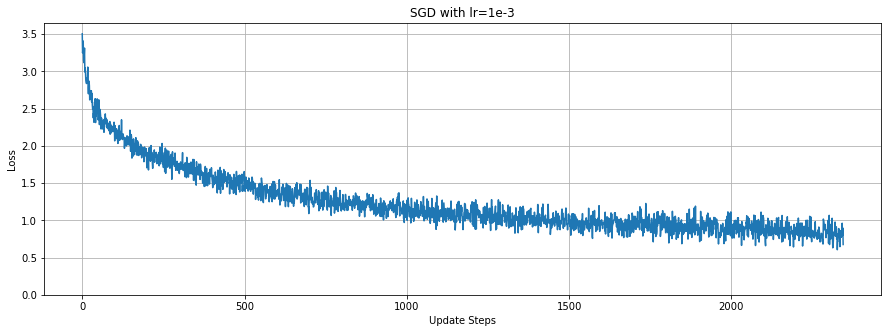

In [16]:
plot_loss(sgd_loss, 'SGD with lr=1e-3')

Looks reasonable, the loss starts at a high value as our parameters are randomly initialized and then proceeds to decrease steadily. We can't really tell how "good" it is without comparing it against another optimizer, so let's go ahead and do that now.

## Optimizer 2: SGD with Momentum

One way to think of SGD is a ball rolling down a hill, where areas of high gradient are steep parts of the hill and areas of low gradient are very flat areas. Sometimes the global minima, the point with the lowest loss, is in the middle of a giant flat area. The problem is that because these flat areas have small gradients they also give small update steps which makes learning slow. 

What if we expanded on the "ball rolling down a hill" analogy? We'd want to add something to our optimizer that made it keep the "momentum" gained rolling down the steep hills whilst it's going across the flat areas. 

Well hey, that's exact what SGD with momentum does! Our parameter update is now calculated using a velocity, $v$, which depends on the current gradient multiplied by the learning rate plus the previous velocity multiplied by the momentum $\gamma$. 

\begin{align*}
    v_{t,i} &= \gamma \cdot v_{t-1,i} + \eta \cdot \nabla_\theta J(\theta_{t,i})\\
    \theta_{t+1,i} &= \theta_{t,i} - v_{t,i}\\
\end{align*}

If momentum is zero then we don't care about the previous velocity at all and this algorithm becomes SGD. Commonly used momentum values are usually around 0.9ish.

PyTorch's optimizers are sometimes a little different from the actual algorithms. PyTorch's version of SGD with momentum moves the learning rate outside the equation for velocity:

\begin{align*}
    v_{t,i} &= \gamma \cdot v_{t-1,i} + \nabla_\theta J(\theta_{t,i})\\
    \theta_{t+1,i} &= \theta_{t,i} - \eta \cdot v_{t,i}\\
\end{align*}

If the PyTorch implementation differs then we'll implement the PyTorch version as we use it as a reference.

Note that the velocity `v` is a list of tensors corresponding to the model parameters, so we are storing the velocity of every single parameter in our model.

In [17]:
class SGDMomentum:
    def __init__(self, model_params, lr=1e-3, momentum=0.9):
        self.model_params = list(model_params)
        self.lr = lr
        self.momentum = momentum
        self.v = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, v in zip(self.model_params, self.v):
            v.mul_(self.momentum).add_(param.grad)
            param.sub_(self.lr * v)

Below we define our SGD with momentum optimizer, train our model and plot the results.

In [18]:
optimizer = SGDMomentum(model.parameters())

In [19]:
sgd_momentum_loss = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 40.48it/s]


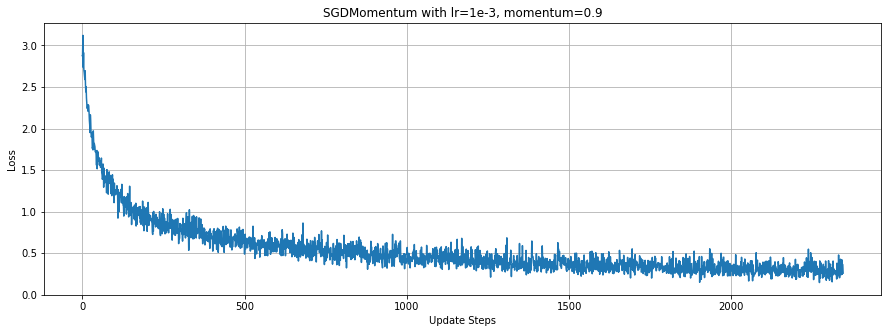

In [20]:
plot_loss(sgd_momentum_loss, 'SGDMomentum with lr=1e-3, momentum=0.9')

Now let's compare SGD and SGD with momentum.

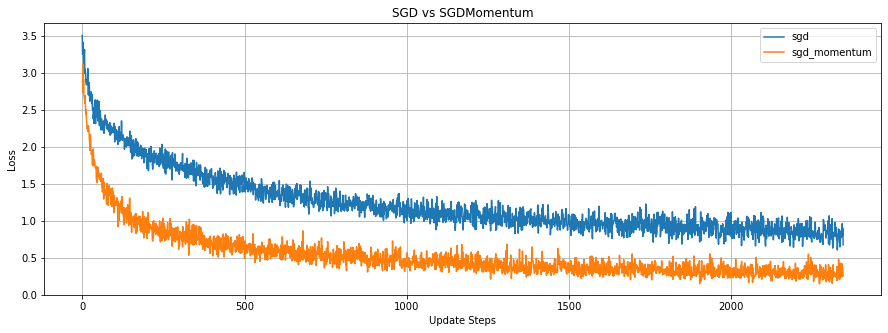

In [21]:
losses = [sgd_loss, sgd_momentum_loss]
labels = ['sgd', 'sgd_momentum']

plot_losses(losses, labels, 'SGD vs SGDMomentum')

As we can see, not only does momentum help us reach the lowest SGD loss, around 1.0, in a fraction of the time it also gives us a lower overall!

There's also another variant of SGD with momentum called **Nesterov Accelerated Gradient** (NAG) but we aren't going to implement it here for a few reasons:

1. There are multiple different ways to implement it, see [this](https://jlmelville.github.io/mize/nesterov.html) excellent article for details on the variations, and PyTorch implements it in a completely different way.
2. I have personally found that it has never provided a noticable improvement over regular momentum.
3. It's not very commonly used.

Let's move on to the next optimizer.

## Optimizer 3: Adagrad

One downside with SGD is that we use a single learning rate across all of our parameters, and that this learning rate is fixed through the entirety of training.

Ideally, parameters that are updated more frequently have a lower learning rate and parameters that are updated infrequently have a larger learning rate.

This is what Adagrad does. We use $G_{t,i}$ which is the sum of the squared gradients for parameter $i$ up to, and including, time-step $t$. $G_{t,i}$ is initialized to some value, usually zero by default. As the square of the gradients of a parameter are accumulated, $G_{t,i}$ increases, and thus reduces the learning rate for parameter $i$. 

$$\theta_{t+1,i} = \theta_{t,i} - \frac{\eta}{\sqrt{G_{t,i}}+\epsilon} \cdot \nabla_\theta J(\theta_{t,i})$$

where:

$$G_{t,i} = G_{t-1,i} + \Big(\nabla_\theta J(\theta_{t,i})\Big)^2$$

$\epsilon$ is very small number, used to avoid division by zero in the denominator. Sometimes you'll see $\epsilon$ inside the square root, and sometimes it will be outside. PyTorch leaves it outside so we will too.

We implement Adagrad below, initializing $G$ as a list of tensors called `acc_sqr_grads` and using `std` to refer to the denominator of the update step equation. 

In [22]:
class Adagrad:
    def __init__(self, model_params, lr=1e-2, init_acc_sqr_grad=0, eps=1e-10):
        self.model_params = list(model_params)
        self.lr = lr
        self.acc_sqr_grads = [torch.full_like(p, init_acc_sqr_grad) for p in self.model_params]
        self.eps = eps

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, acc_sqr_grad in zip(self.model_params, self.acc_sqr_grads):
            acc_sqr_grad.add_(param.grad * param.grad)
            std = acc_sqr_grad.sqrt().add(self.eps)
            param.sub_((self.lr / std) * param.grad)

In [23]:
optimizer = Adagrad(model.parameters())

In [24]:
adagrad_loss = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 41.54it/s]


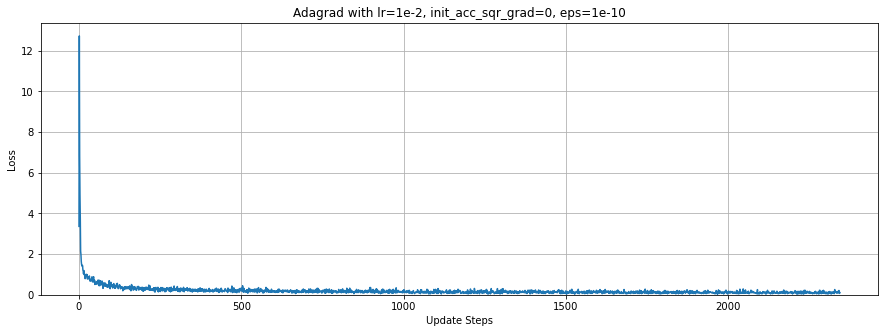

In [25]:
plot_loss(adagrad_loss, 'Adagrad with lr=1e-2, init_acc_sqr_grad=0, eps=1e-10')

We can see there's an initial large spike in the loss value. This is due to the initial $G$ values being very small and thus the learning rate is divided by a very small number making it very large. Very large learning rates usually lead to unstable training which give higher loss values.

Let's trim the start to get a better view what the final loss value is.

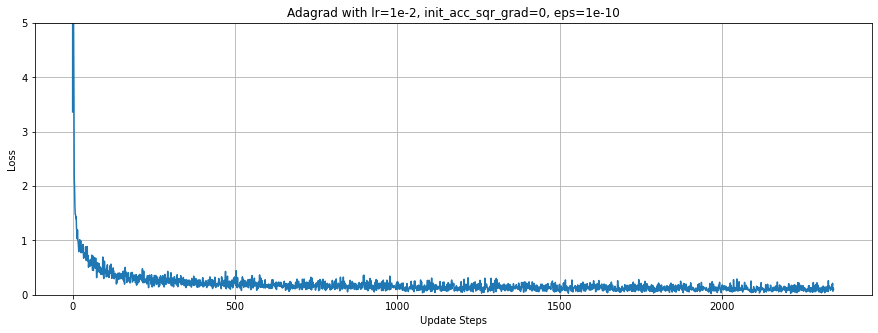

In [26]:
plot_loss(adagrad_loss, 'Adagrad with lr=1e-2, init_acc_sqr_grad=0, eps=1e-10', ymax=5.0)

Let's compare our Adagrad loss to our SGD algorithms.

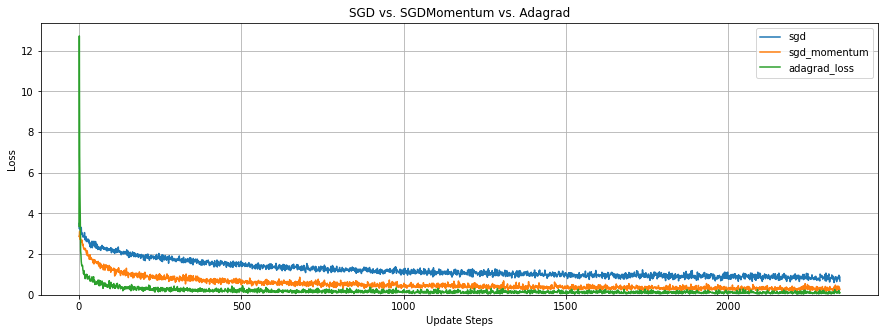

In [27]:
losses = [sgd_loss, sgd_momentum_loss, adagrad_loss]
labels = ['sgd', 'sgd_momentum', 'adagrad_loss']

plot_losses(losses, labels, 'SGD vs. SGDMomentum vs. Adagrad')

Adagrad beats the other two pretty handily, but that initial spike in loss doesn't look very nice. Maybe if we get rid of that initial spike we can make Adagrad perform even better? Let's try some different initial values for $G$ and store them all in a `adagrad_losses` dictionary. Each key in the dictionary will be the initial $G$ value and the values of the dictionary will be a list of training loss per batch.

In [28]:
adagrad_losses = {0: adagrad_loss}

In [29]:
optimizer = Adagrad(model.parameters(), init_acc_sqr_grad=1.0)

In [30]:
adagrad_losses[1.0] = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 40.53it/s]


In [31]:
optimizer = Adagrad(model.parameters(), init_acc_sqr_grad=0.1)

In [32]:
adagrad_losses[0.1] = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 40.42it/s]


In [33]:
optimizer = Adagrad(model.parameters(), init_acc_sqr_grad=0.01)

In [34]:
adagrad_losses[0.01] = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 40.26it/s]


In [35]:
optimizer = Adagrad(model.parameters(), init_acc_sqr_grad=0.001)

In [36]:
adagrad_losses[0.001] = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 39.75it/s]


Now let's compare all of our four values for the initial $G$ value.

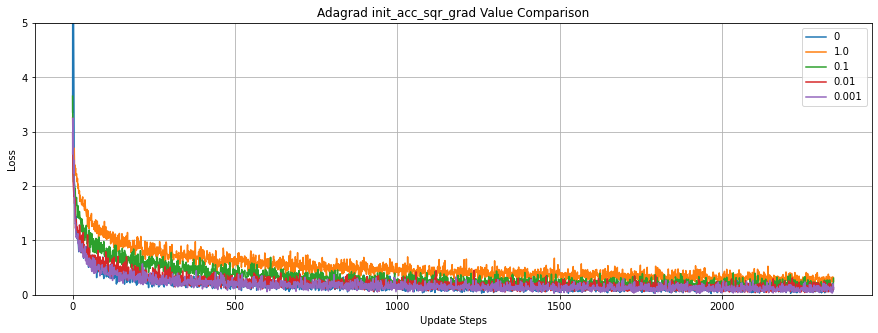

In [37]:
labels, losses = zip(*adagrad_losses.items())

plot_losses(losses, labels, 'Adagrad init_acc_sqr_grad Value Comparison', ymax=5.0)

As we can see, performance of Adagrad increases as the initial $G$ value decreases, but decreasing $G$ also increases the initial spike in loss at the beginning of training.

Why does the performance decrease as the initial $G$ value increases? This is the major downside of Adagrad: as $G$ is monotonically increasing at each time-step it will be dividing the learning rate by a monotonically increasing number at each time-step. This causes the size of the steps taken to reduce every update step. As the results for an initial $G$ value of 1.0 show, we can see that these smaller step sizes actually increase the time taken for the model to converge, and in extreme cases will cause the step sizes to approach zero meaning the parameters will stop updating completely. 

In practice, we do want the learning rate to decrease whilst training, but ideally would not want it to become zero. 

Let's compare Adagrad against the SGD optimizers with the large initial spike trimmed off, so we can get a better view of how they compare.

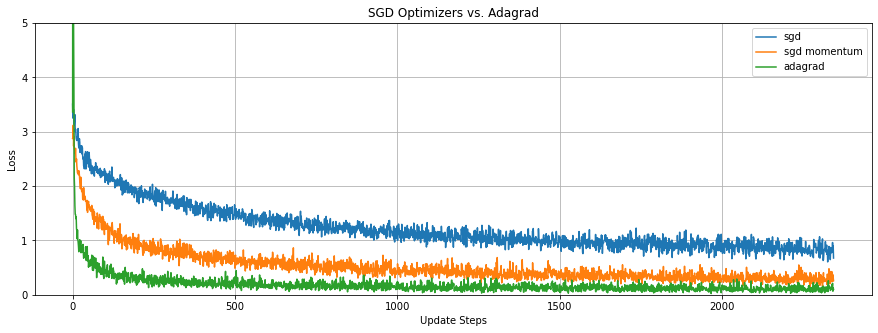

In [38]:
losses = [sgd_loss, sgd_momentum_loss, adagrad_loss]
labels = ['sgd', 'sgd momentum', 'adagrad']

plot_losses(losses, labels, 'SGD Optimizers vs. Adagrad', ymax=5.0)

## Optimizer 4: Adadelta

All of our update step equations can be written in the form of:

$$\theta_{t+1,i} = \theta_{t,i} + \Delta \theta_{t,i}$$

where $\Delta \theta_{t,i}$ is the size of the parameter update, i.e. in SGD we had: 

$$\Delta \theta_{t,i} = - \eta \cdot \nabla_\theta J(\theta_{t,i})$$

and in Adagrad we had: 

$$\Delta \theta_{t,i} = - \frac{\eta}{\sqrt{G_{t,i}}+\epsilon} \cdot \nabla_\theta J(\theta_{t,i}))$$

The problem of the Adagrad algorithm was that $G$ was monotonically increasing. Adadelta solves this problem by first taking the Adagrad algorithm and replacing $G_{t,i}$ with $E[g^2]_{t,i}$, an exponential moving average of the square of the gradients so far.

$$E[g^2]_{t,i} = \rho E[g^2]_{t-1,i} + (1-\rho)g^2_{t,i}$$

where $g_{t,i} = \nabla_\theta J(\theta_{t,i})$, which we've done just to simplify the notation, and $\rho$ controls how much we care about the previous gradients in the exponential moving average, $\rho=0$ means we don't care about them at all.

This means our update step equation is:

$$\Delta \theta_t = - \frac{\eta}{\sqrt{E[g^2]_{t,i} + \epsilon}} \cdot g_{t,i}$$

Notice that the $\epsilon$ term has now moved inside the square root, which we're copying from PyTorch. 

The problem with the above equation, and in fact all update equations seen so far, is the units of the update do not match the units of the parameters. The updates have units of $\frac{\delta J}{\delta \theta}$, which simplify to $\frac{1}{\text{units of }\theta}$ if we assume the cost function is unitless. However, we want our update equations to have units of $\theta$. 

To solve this the Adadelta equation uses a second exponential moving average, but this one is of the parameter updates.

To get the final Adadelta equation, we take our first attempt, but replace $\eta$ with an exponential moving average of the squared parameter updates:

$$E[\Delta \theta^2]_{t-1,i} = \rho E[\Delta \theta^2]_{t-2,i} + (1-\rho)\Delta \theta^2_{t-1,i}$$

Thus, we get:

$$\Delta \theta_{t,i} = - \frac{\sqrt{E[\Delta \theta^2]_{t-1,i} + \epsilon}}{\sqrt{E[g^2]_{t,i}+\epsilon}} \cdot g_{t,i}$$

The units now "match" as we now have units of $\frac{\theta^2}{\theta} = \theta$.

This means that we do not even need to use a learning rate value, however in the PyTorch implementation they do use one (which defaults to 1.0), so they end up with:

$$\Delta \theta_{t,i} = - \eta \cdot \frac{\sqrt{E[\Delta \theta^2]_{t-1,i} + \epsilon}}{\sqrt{E[g^2]_{t,i}+\epsilon}} \cdot g_{t,i}$$

Thus:

$$\theta_{t+1,i} = \theta_{t,i} - \eta \cdot \frac{\sqrt{E[\Delta \theta^2]_{t-1,i} + \epsilon}}{\sqrt{E[g^2]_{t,i}+\epsilon}} \cdot g_{t,i}$$

PyTorch also changes default `eps` value from what it was in Adagrad, from `1e-10` to `1e-6`.

In [39]:
class Adadelta:
    def __init__(self, model_params, lr=1.0, rho=0.9, eps=1e-6):
        self.model_params = list(model_params)
        self.lr = lr
        self.rho = rho
        self.eps = eps
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_sqr_deltas = [torch.zeros_like(p) for p in self.model_params] 

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad, avg_sqr_delta in zip(self.model_params, \
                                                      self.avg_sqr_grads, \
                                                      self.avg_sqr_deltas):
            avg_sqr_grad.mul_(self.rho).add_(param.grad * param.grad * (1 - self.rho))
            std = avg_sqr_grad.add(self.eps).sqrt()
            delta = avg_sqr_delta.add(self.eps).sqrt().div(std).mul(param.grad)
            param.sub_(self.lr * delta)
            avg_sqr_delta.mul_(self.rho).add_(delta * delta * (1 - self.rho))

In [40]:
optimizer = Adadelta(model.parameters())

In [41]:
adadelta_loss = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 41.21it/s]


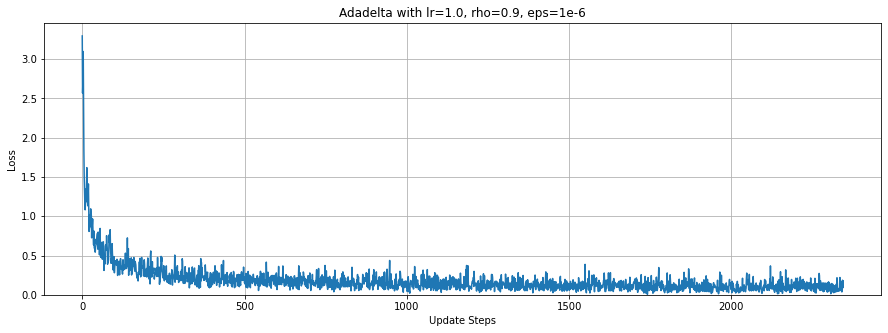

In [42]:
plot_loss(adadelta_loss, 'Adadelta with lr=1.0, rho=0.9, eps=1e-6')

We can see that we avoid the large initial spike in loss due to the numerator term (the exponential moving average of parameter updates) starting out very small. 

Let's compare Adadelta to all the other algorithms so far.

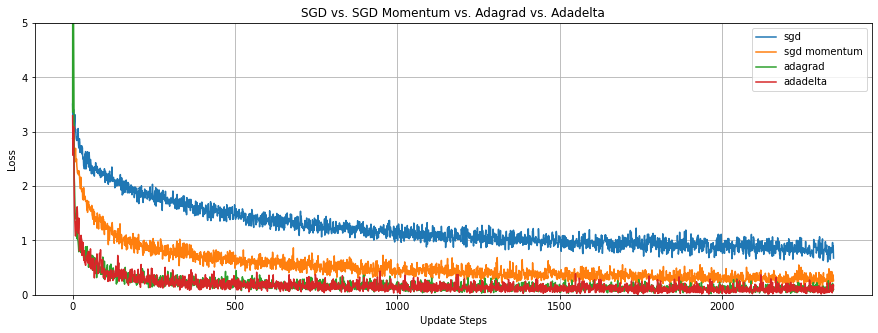

In [43]:
losses = [sgd_loss, sgd_momentum_loss, adagrad_loss, adadelta_loss]
labels = ['sgd', 'sgd momentum', 'adagrad', 'adadelta']

plot_losses(losses, labels, 'SGD vs. SGD Momentum vs. Adagrad vs. Adadelta', ymax=5.0)

We can see that Adagrad and Adadelta have pretty much equal performance, but Adadelta doesn't have the large initial spike in loss.

## Optimizer 5: RMSprop

Remember that "first attempt" at the Adadelta equation? The one that we said had the issue of the update units not matching the parameter units? Turns out you can completely ignore the fact that these units don't match up and this gives you the RMSprop algorithm!

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g^2]_{t,i} + \epsilon}} \cdot g_{t,i}$$

In PyTorch, they move the $\epsilon$ term back outside of the square root, similar to Adagrad. This gives us:

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g^2]_{t,i}} + \epsilon} \cdot g_{t,i}$$

In the PyTorch implementation they also change the default learning rate to `1e-2`, rename `rho` to `alpha` whilst giving it a new default value of `0.99`, and also change the default `eps` to `1e-8`.

In [44]:
class RMSprop:
    def __init__(self, model_params, lr=1e-2, alpha=0.99, eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad in zip(self.model_params, self.avg_sqr_grads):
            avg_sqr_grad.mul_(self.alpha).add_(param.grad * param.grad * (1 - self.alpha))
            std = avg_sqr_grad.sqrt().add(self.eps)
            param.sub_((self.lr / std) * param.grad)

In [45]:
optimizer = RMSprop(model.parameters())

In [46]:
rmsprop_loss = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 40.14it/s]


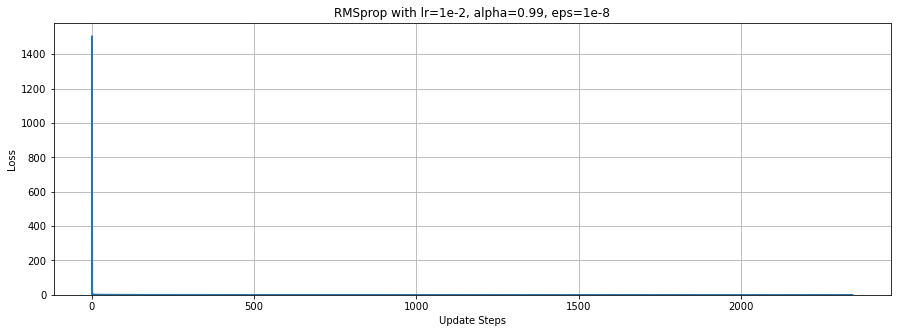

In [47]:
plot_loss(rmsprop_loss, 'RMSprop with lr=1e-2, alpha=0.99, eps=1e-8')

We run into a similar issue as we did with Adagrad, the small denominator in the initial time-steps lead to large step sizes which give huge spikes in loss values during the early stages of training.

Let's zoom in to the interesting bit to get a better view of what's going on.

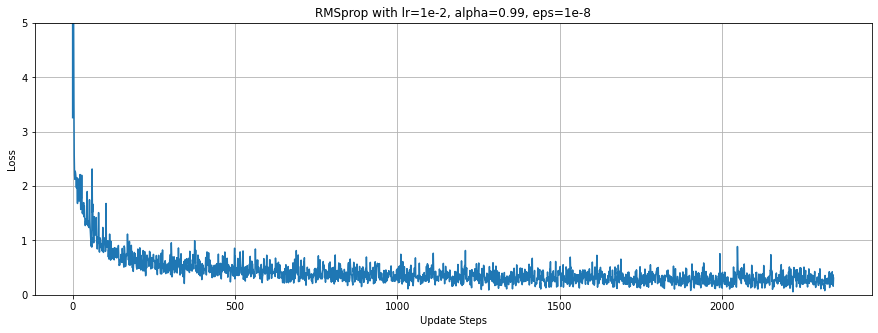

In [48]:
plot_loss(rmsprop_loss, 'RMSprop with lr=1e-2, alpha=0.99, eps=1e-8', ymax=5.0)

One thing to note is that the PyTorch implementation of RMSprop differs from the TensorFlow implementation in two main ways. In TensorFlow the $\epsilon$ term is inside the square root, as it is in the initial RMSprop algorithm, and the exponential moving average of the squared gradients is initialized to ones instead of zeros. 

This TensorFlow variant is [apparently more stable](https://github.com/pytorch/pytorch/issues/23796) than the PyTorch version, so we'll implement it here and see if it provides any noticeable improvement.

In [49]:
class RMSpropAlt:
    def __init__(self, model_params, lr=1e-2, alpha=0.99, eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.avg_sqr_grads = [torch.ones_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad in zip(self.model_params, self.avg_sqr_grads):
            avg_sqr_grad.mul_(self.alpha).add_(param.grad * param.grad * (1 - self.alpha))
            std = avg_sqr_grad.add(self.eps).sqrt()
            param.sub_((self.lr / std) * param.grad)

In [50]:
optimizer = RMSpropAlt(model.parameters())
rmspropalt_loss = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 39.85it/s]


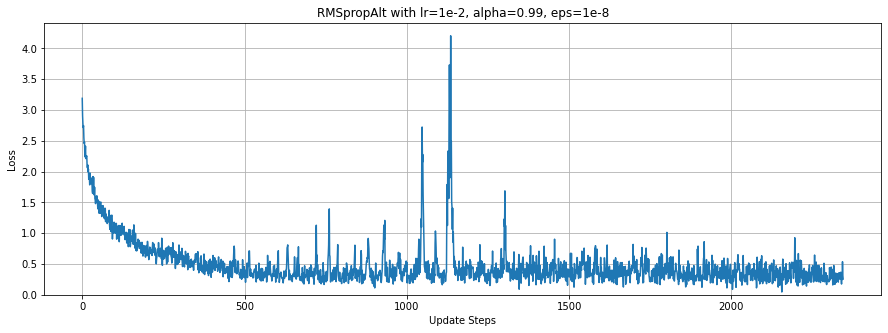

In [51]:
plot_loss(rmspropalt_loss, 'RMSpropAlt with lr=1e-2, alpha=0.99, eps=1e-8')

The TensorFlow variant doesn't have the large initial spikes in loss, but it actually looks **less** stable than the PyTorch RMSprop implementation, even when ignoring the large spikes during training.

Let's compare the two.

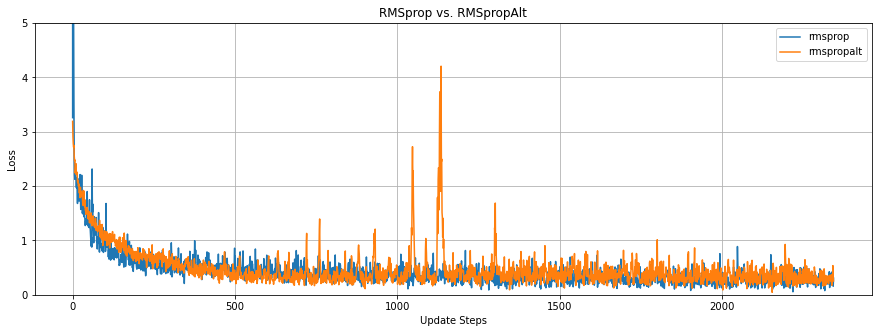

In [52]:
losses = [rmsprop_loss, rmspropalt_loss]
labels = ['rmsprop', 'rmspropalt']

plot_losses(losses, labels, 'RMSprop vs. RMSpropAlt', ymax=5.0)

The TensorFlow variant is definitely less stable. However, this is an experiment with a sample size of one, so we can't make any general claims about these two RMSprop versions.

Let's do a quick comparison of these two against Adagrad and Adadelta:

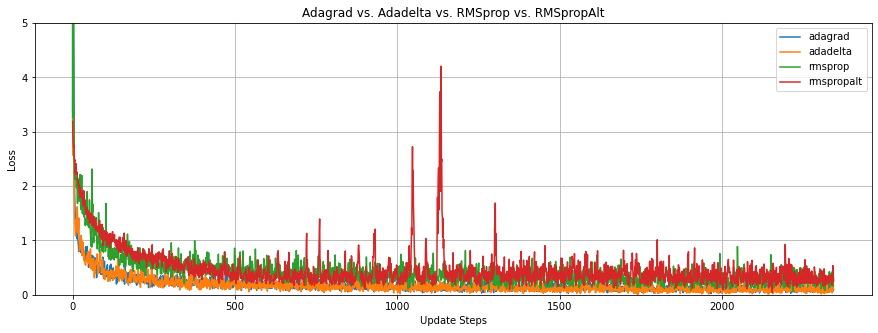

In [53]:
losses = [adagrad_loss, adadelta_loss, rmsprop_loss, rmspropalt_loss]
labels = ['adagrad', 'adadelta', 'rmsprop', 'rmspropalt']

plot_losses(losses, labels, 'Adagrad vs. Adadelta vs. RMSprop vs. RMSpropAlt', ymax=5.0)

We can see that both RMSprop variants aren't as good as Adagrad or Adadelta.

RMSprop is commonly used in reinforcement learning and one hyperparameter that's tweaked a lot is the `eps` parameter. Let's try a few values and see if they make any difference in our experimental set-up.

In [54]:
rmsprop_losses = {1e-8: rmsprop_loss}

In [55]:
optimizer = RMSprop(model.parameters(), eps=1e-6)

In [56]:
rmsprop_losses[1e-6] = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 40.18it/s]


In [57]:
optimizer = RMSprop(model.parameters(), eps=1e-4)

In [58]:
rmsprop_losses[1e-4] = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 39.80it/s]


In [59]:
optimizer = RMSprop(model.parameters(), eps=1e-2)

In [60]:
rmsprop_losses[1e-2] = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 40.65it/s]


In [61]:
optimizer = RMSprop(model.parameters(), eps=1)

In [62]:
rmsprop_losses[1] = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 40.70it/s]


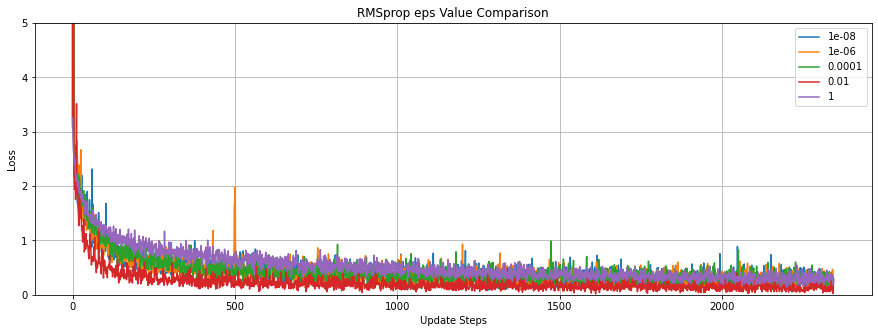

In [63]:
labels, losses = zip(*rmsprop_losses.items())

plot_losses(losses, labels, 'RMSprop eps Value Comparison', ymax=5.0)

Increasing `eps` improves performance to a point, `eps=1e-2` gives the best performance, and then performance starts degrading, `eps=1` gives the worst performance.

Let's try the same thing with the TensorFlow variant of RMSprop.

In [64]:
rmspropalt_losses = {1e-8: rmspropalt_loss}

In [65]:
optimizer = RMSpropAlt(model.parameters(), eps=1e-6)

In [66]:
rmspropalt_losses[1e-6] = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 40.05it/s]


In [67]:
optimizer = RMSpropAlt(model.parameters(), eps=1e-4)

In [68]:
rmspropalt_losses[1e-4] = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 39.96it/s]


In [69]:
optimizer = RMSpropAlt(model.parameters(), eps=1e-2)

In [70]:
rmspropalt_losses[1e-2] = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 40.96it/s]


In [71]:
optimizer = RMSpropAlt(model.parameters(), eps=1)

In [72]:
rmspropalt_losses[1] = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 41.81it/s]


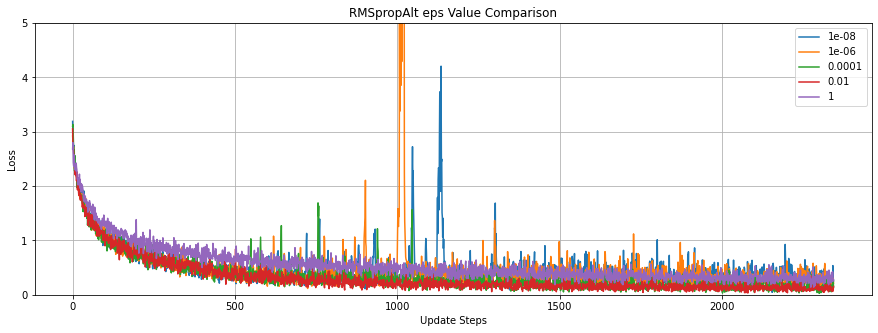

In [73]:
labels, losses = zip(*rmspropalt_losses.items())

plot_losses(losses, labels, 'RMSpropAlt eps Value Comparison', ymax=5.0)

We get a similar thing happening here, it looks like the best `eps` value is also around `1e-2`.

Let's compare the two RMSprop variants with an `eps=1e-2`.

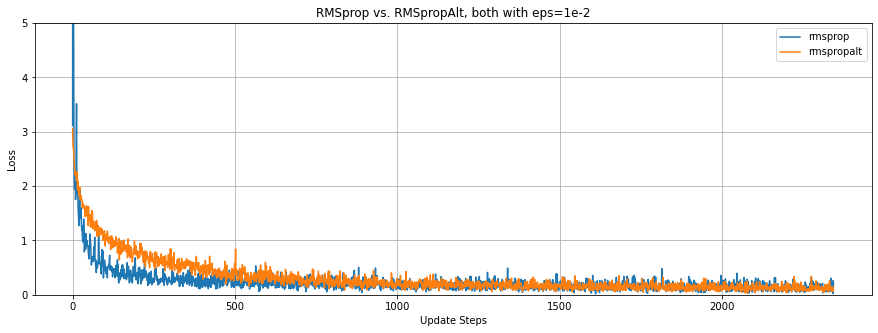

In [74]:
losses = [rmsprop_losses[1e-2], rmspropalt_losses[1e-2]]
labels = ['rmsprop', 'rmspropalt']

plot_losses(losses, labels, 'RMSprop vs. RMSpropAlt, both with eps=1e-2', ymax=5.0)

Looks like the PyTorch variant of RMSprop is still better (converges to the minimum loss faster), so now let's compare it against Adagrad and Adadelta again.

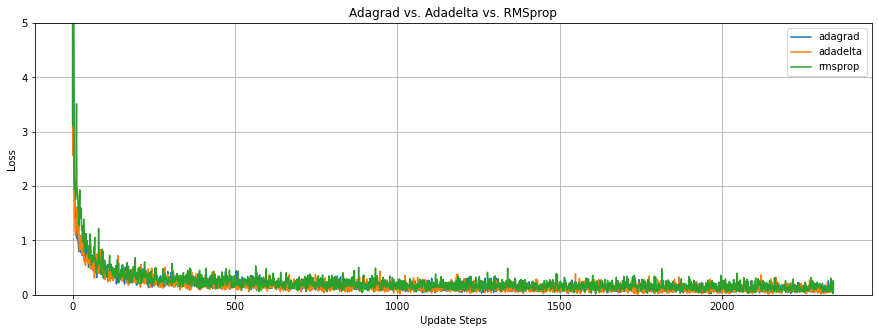

In [75]:
losses = [adagrad_loss, adadelta_loss, rmsprop_losses[1e-2]]
labels = ['adagrad', 'adadelta', 'rmsprop']

plot_losses(losses, labels, 'Adagrad vs. Adadelta vs. RMSprop', ymax=5.0)

They're all very close, maybe RMSprop is slightly worse?

Let's zoom in.

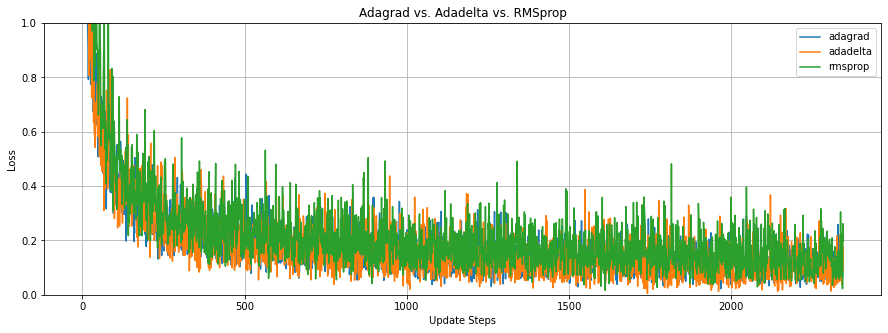

In [76]:
losses = [adagrad_loss, adadelta_loss, rmsprop_losses[1e-2]]
labels = ['adagrad', 'adadelta', 'rmsprop']

plot_losses(losses, labels, 'Adagrad vs. Adadelta vs. RMSprop', ymax=1.0)

It's still a bit hard to tell.

How about we smooth the loss curves with a moving average?

In [77]:
def moving_average(x, w=5):
    return np.convolve(x, np.ones(w), 'valid') / w

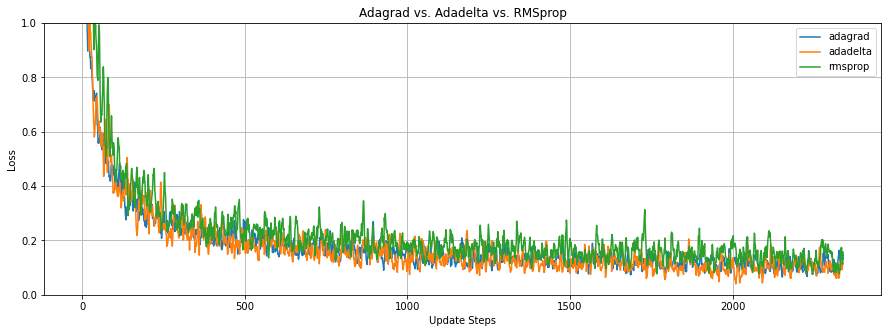

In [78]:
losses = [adagrad_loss, adadelta_loss, rmsprop_losses[1e-2]]
smoothed_losses = [moving_average(loss) for loss in losses]
labels = ['adagrad', 'adadelta', 'rmsprop']

plot_losses(smoothed_losses, labels, 'Adagrad vs. Adadelta vs. RMSprop', ymax=1.0)

RMSprop is looks like it's the worst of the three, but not really by a lot.

Before we ruin our eyes by squinting at loss curves for hours, let's move on to the final optimization algorithm: Adam.

## Optimizer 6: Adam

RMSprop's idea of annealing the step size over time, whilst using an exponential moving average to avoid saturation, seemed to work out OK. What if we added momentum to it? That's how you get Adam.

Adam has an exponential moving average of the gradients, like the momentum term that can be added to SGD, and an exponential moving average of squared gradients, like RMSprop and Adadelta.

$$\theta_{t+1} = \theta_t - \eta \cdot \frac{m_{t,i}}{\sqrt{v_{t,i}}+\epsilon}$$

where:

\begin{align*}
    m_{t,i} &= \beta_1 m_{t-1,i} + (1-\beta_1)g_{t,i} \\
    v_{t,i} &= \beta_2 v_{t-1,i} + (1-\beta_2)g_{t,i}^2
\end{align*}

Adam's $m_{t,i}$ is equal to $v_{t,i}$ from SGD with momentum if it had a $(1-\gamma)$ term. Adam's $v_{t,i} = E[g^2]_{t,i}$ from RMSprop and Adadelta, with $\rho$ replaced by $\beta_2$.

As $m$ and $v$ are initialized to zero and $\beta_1$ and $\beta_2$ are initialized close to one the $m$ and $v$ values calculated on the first few update steps are "biased" towards very small values. This is why we saw a huge loss for the first steps of Adagrad, Adadelta and RMSprop. 

To solve this, Adam uses "bias corrected" values of $m$ and $v$, calculated as:

\begin{align*}
    \hat{m}_{t,i} &= \frac{m_{t,i}}{1-\beta_1^t} \\
    \hat{v}_{t,i} &= \frac{v_{t,i}}{1-\beta_2^t}
\end{align*}

This gives the final Adam equation as:

$$\theta_{t+1} = \theta_t - \eta \cdot \frac{\hat{m}_{t,i}}{\sqrt{\hat{v}_{t,i}}+\epsilon}$$

Note that the bias corrected values on the first call to `step` are calculated with $t = 1$ and not $t = 0$.

In [79]:
class Adam:
    def __init__(self, model_params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.beta_1, self.beta_2 = betas
        self.eps = eps
        self.avg_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        self.n_steps = 0
        
    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_grad, avg_sqr_grad in zip(self.model_params, \
                                                 self.avg_grads, \
                                                 self.avg_sqr_grads):
            self.n_steps += 1
            avg_grad.mul_(self.beta_1).add_(param.grad * (1 - self.beta_1))
            avg_sqr_grad.mul_(self.beta_2).add_(param.grad * param.grad * (1 - self.beta_2))
            avg_grad_corrected = avg_grad.div(1 - self.beta_1 ** self.n_steps)
            avg_sqr_grad_corrected = avg_sqr_grad.div(1 - self.beta_2 ** self.n_steps)
            std = avg_sqr_grad_corrected.sqrt().add(self.eps)
            param.sub_(self.lr * avg_grad_corrected / std)

In [80]:
optimizer = Adam(model.parameters())

In [81]:
adam_loss = train(train_iterator, model, optimizer, criterion, device)

100%|█████████████████████████████████████████| 469/469 [00:11<00:00, 39.26it/s]


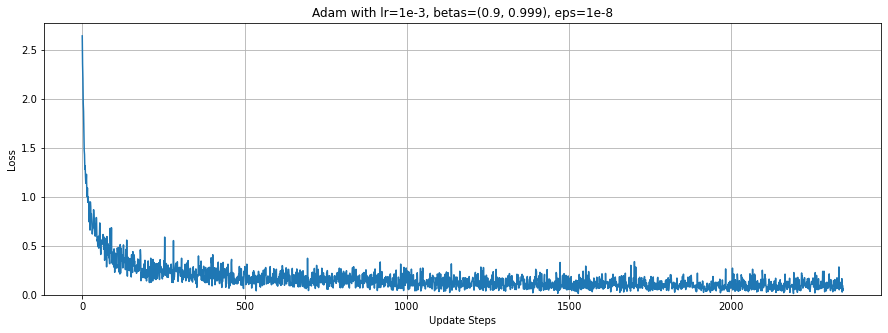

In [82]:
plot_loss(adam_loss, 'Adam with lr=1e-3, betas=(0.9, 0.999), eps=1e-8')

Looks good so far, no large spike in losses. Let's compare it against the other optimization algorithms.

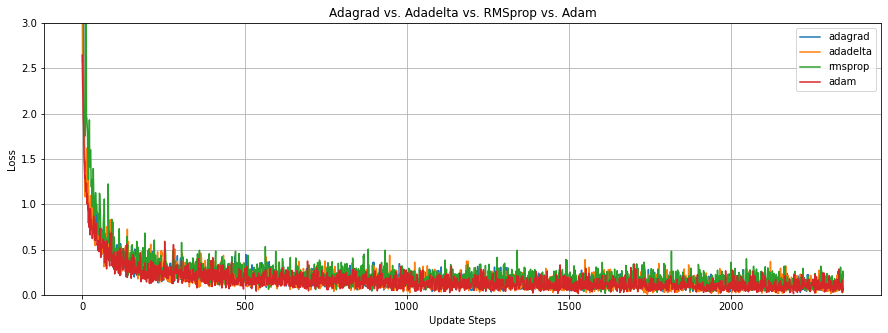

In [83]:
losses = [adagrad_loss, adadelta_loss, rmsprop_losses[1e-2], adam_loss]
labels = ['adagrad', 'adadelta', 'rmsprop', 'adam']

plot_losses(losses, labels, 'Adagrad vs. Adadelta vs. RMSprop vs. Adam', ymax=3.0)

Adam seems to be in line with Adagrad and Adadelta, though better than RMSprop. 

Let's check by zooming in.

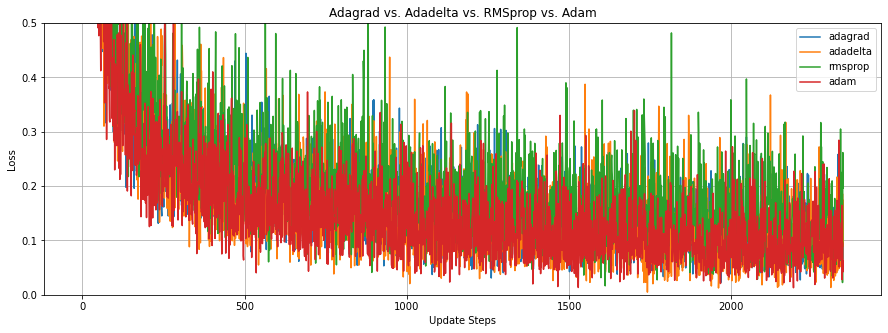

In [84]:
losses = [adagrad_loss, adadelta_loss, rmsprop_losses[1e-2], adam_loss]
labels = ['adagrad', 'adadelta', 'rmsprop', 'adam']

plot_losses(losses, labels, 'Adagrad vs. Adadelta vs. RMSprop vs. Adam', ymax=0.5)

Again, all looks pretty equal between Adagrad, Adadelta and Adam. 

We can perform a running average over the training losses to see if this helps find a clear winner.

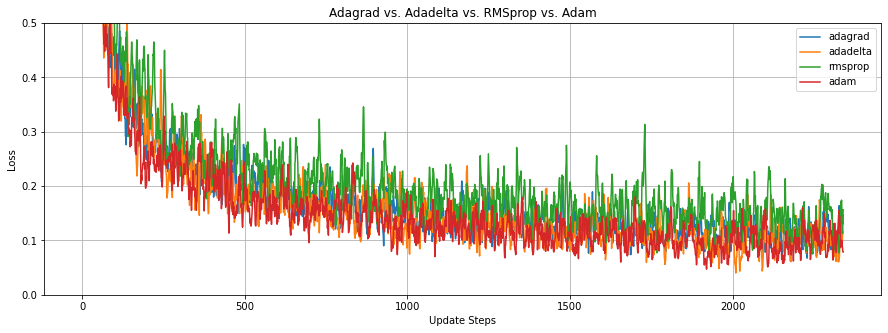

In [85]:
losses = [adagrad_loss, adadelta_loss, rmsprop_losses[1e-2], adam_loss]
smoothed_losses = [moving_average(loss) for loss in losses]
labels = ['adagrad', 'adadelta', 'rmsprop', 'adam']

plot_losses(smoothed_losses, labels, 'Adagrad vs. Adadelta vs. RMSprop vs. Adam', ymax=0.5)

Nope, no clear winner. Looks like Adagrad, Adadelta and Adam are all pretty much equal for this experimental set-up.

## Conclusion

In this notebook we've gone through the following optimization algorithms:

* SGD
* SGD with momentum
* Adagrad
* Adadelta
* RMSprop
* Adam

Hopefully we've learned a bit more about these algorithms and no longer have to treat them as mystical black boxes that we have to worship in order to achieve convergence.

Our experiments have shown that all the adaptive learning rate algorithms beat the fixed learning rate algorithms. Out of those adaptive learning rate algorithms, RMSprop is clearly in last, however the remaining three: Adagrad, Adadelta and Adam are all pretty much equal.

As mentioned at the beginning of this notebook, these experiments show the performance of each optimization algorithm on a single model architecture and task, all on a single seed. Just because RMSprop loses to Adam here, doesn't mean it will always do so.